In [1]:
from math import nan
from copy import deepcopy
from datetime import datetime
import itertools
from multiprocessing import Pool
import pickle
from pathlib import Path

In [2]:
import numpy as np
import numpy.random
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier

In [4]:
from load import read_data, read, write, get_full_prepared_data_with_upsample
from processing import start_processing
from parameters import RANDOM_SEED, SCORERS, TARGET_FEATURE, TEST_SIZE, THREADS
from preparing import (MyOheHotEncoder, MyOrdinalEncoder, MyMinMaxScaler, ColumnsSorter,
                       EmptyColFiller, MyPolynomialFeatures, ordinal_encoding, one_hot_encoding)
from model_preparing import simple_linear, simple_forest, simple_catboost, fast_catboost
from tuning import try_each_col, try_wo_each_col, try_cols_in_order, try_sets_of_cols

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_info_columns', 1000)

In [6]:
f, ft, fp, inverse_target_replacer = get_full_prepared_data_with_upsample()

In [7]:
# n = len(cols_4_2)
# k = 12
# f = numpy.math.factorial
# print(n, k)
# f(n) / (f(n-k) * f(k))

In [8]:
%%time
cols_4_2 = [x for x in list(f.columns) if x != TARGET_FEATURE]
if True or not Path('cols_sets.pickle').exists():
    cols_sets = []
    for i_n in range(5, len(cols_4_2)):
        cols_sets.extend([list(x) for x in itertools.combinations(cols_4_2, i_n)])
    numpy.random.shuffle(cols_sets)
#     write('cols_sets.pickle', cols_sets)

# cols_sets = read('cols_sets.pickle')

Wall time: 0 ns


In [9]:
# %%time
# cols_4_1 = ('condition', 'start_year', 'group_code_add_0_2', 'faculty', 'group_code_add_2_1', 'group_code_add_1_1', 'mean_mark', 'school_type', 'years_old', 'start_year_val_exp3_scale_fun', 'start_year_val_r_scale_fun', 'group_code_add_3_2', 'years_old_exp5_scale_fun', 'gender', 'group_code_add_1_2', 'birthday_year', 'years_old_r_scale_fun', 'years_old_exp3_scale_fun', 'start_year_val_sqrt_scale_fun', 'start_year_val_expexp_scale_fun',
#             'mean_mark_type2', 'mean_mark_type1', 'mean_mark_add2', 'mean_mark_add1', 'city', 'group_code', 'group_code_add_2_2', 'group_code_add_3_1', 'start_year_val_rexp5_scale_fun', 'diff_between_school_n_start_exp5_scale_fun')
# cols_4_2 = [x for x in cols_4_1 if 'random' not in x]
# skeys = ('group_code', 'start_year', 'mean_mark', 'years_old', 'diff_between_school_n_start')
# fkeys = [x for x in cols_4_2 if any([y in x for y in skeys])]
# fskeys = {x: [y for y in skeys if y in x][0] for x in fkeys}
# if not Path('cols_sets.pickle').exists():
#     cols_sets = []
#     for x in itertools.combinations(cols_4_1, 25):
#         temp = []
#         switcher = {n: 0 for n in skeys}
#         for ix in x:
#             if ix not in fkeys:
#                 temp.append(ix)
#             elif switcher[fskeys[ix]] < 3:
#                 temp.append(ix)
#                 switcher[fskeys[ix]] += 1
#         if len(temp) >= 15:
#             temp = tuple(sorted(temp))
#             # if temp not in cols_sets:
#             cols_sets.append(temp)
#     cols_sets = [list(x) for x in set(cols_sets)]
#     numpy.random.shuffle(cols_sets)
#     write('cols_sets.pickle', cols_sets)

# cols_sets = read('cols_sets.pickle')

In [10]:
# %%time
# # 22:47 - последние с boosting ordered
# get_name = lambda cols: f"models/cb_{'_'.join(sorted([str(cols_4_2.index(x)) for x in cols]))}.pickle"
# print(len(cols_sets), max(map(len, cols_sets)))
# cols_sets = [x for x in cols_sets if not Path(get_name(x)).exists()]
# print(len(cols_sets), max(map(len, cols_sets)))
# #cols_sets = [x for x in cols_sets if len(x) >= max(map(len, cols_sets))] + [x for x in cols_sets if len(x) >= (max(map(len, cols_sets)) - 1)]
# #print(len(cols_sets), max(map(len, cols_sets)))
# step = 2
# n = (len(cols_sets) // step) + 1
# for i in range(n):
#     cols = cols_sets[i * step:((i + 1) * step if (i + 1) * step < len(cols_sets) else len(cols_sets))]
#     pr = try_sets_of_cols(simple_catboost, ft, cols, parallel=False)
#     for (ipr, row), icols in zip(pr.iterrows(), cols):
#         row['cols'] = tuple(sorted(icols))
#         write(get_name(icols), row)

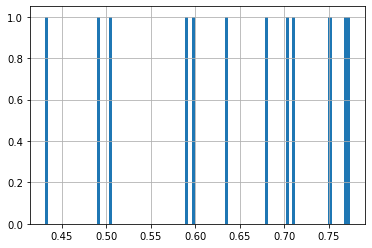

In [11]:
dr = [read(i) for i in Path('models').glob('*.pickle')]
result = pd.concat(dr, axis=1).T
result['test'].hist(bins=100)
result = result[result['test'] > 0.75]

<AxesSubplot:>

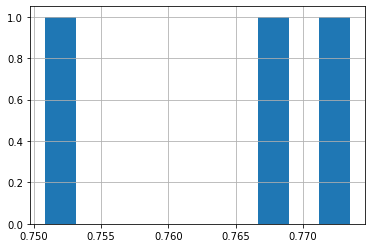

In [12]:
result['test'].hist(bins=10)

In [13]:
def predict(data):
    r = pd.concat([pd.Series(row['model'].predict(data[list(row['cols'])]).squeeze()) for _, row in result.iterrows()], axis=1)
    t0 = r.mode(axis=1)[0]
    t0.name = 'Статус'
    t0.index = data.index
    t0.index.name = 'ID'
    return t0
print('prediction:', SCORERS[0]._score_func(ft[3], predict(ft[2]), average='macro'))
t0 = predict(fp)
display(pd.concat([t0.value_counts() / t0.value_counts().sum(), f[TARGET_FEATURE].value_counts() / f[TARGET_FEATURE].value_counts().sum()], axis=1))
t0 = t0.replace(inverse_target_replacer)

KeyError: "['community'] not in index"

In [ ]:
t0.to_csv(f"res_{datetime.today().strftime('%Y.%m.%d_%H.%M')}.csv")
t0.to_csv(f"res.csv")